In [1]:
import requests
import pandas as pd
import numpy as np
from IPython.display import display
from bs4 import BeautifulSoup
import re
from requests_futures.sessions import FuturesSession
import datetime
from Data.data_country import *
from Visualization.visualization import *

In [2]:
TOP_UNI_URL = "https://www.topuniversities.com"
start = datetime.datetime.now()

In [3]:
r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt')
json = r.json()['data']
#print(json)

In [4]:
def getLink(x):
    soup = BeautifulSoup(x, 'html.parser')
    link = soup.find("a")
    return pd.Series([TOP_UNI_URL + link.get("href"),link.text],index = ['url','name'])

In [5]:
df = pd.DataFrame(json)
df = df[['region','overall_rank','location','uni']]
df_temp = df.apply(lambda x: getLink(x['uni']),axis = 1)
df = df.drop('uni',1)
df = df.join(df_temp)

display(df)

,region,overall_rank,location,url,name
0,North America,1,United States,https://www.topuniversities.com/universities/m...,Massachusetts Institute of Technology (MIT)
1,North America,2,United States,https://www.topuniversities.com/universities/s...,Stanford University
2,North America,3,United States,https://www.topuniversities.com/universities/h...,Harvard University
3,North America,4,United States,https://www.topuniversities.com/universities/c...,California Institute of Technology (Caltech)
4,Europe,5,United Kingdom,https://www.topuniversities.com/universities/u...,University of Cambridge
5,Europe,6,United Kingdom,https://www.topuniversities.com/universities/u...,University of Oxford
6,Europe,7,United Kingdom,https://www.topuniversities.com/universities/u...,UCL (University College London)
7,Europe,8,United Kingdom,https://www.topuniversities.com/universities/i...,Imperial College London
8,North America,9,United States,https://www.topuniversities.com/universities/u...,University of Chicago
9,Europe,10,Switzerland,https://www.topuniversities.com/universities/e...,ETH Zurich - Swiss Federal Institute of Techno...


In [6]:
def find_number(soup, list_dict_div):
    current_soup = soup
    for dict_div in list_dict_div:
        current_soup = current_soup.find("div",dict_div)
        if(current_soup is None):
            return 0
    return int(current_soup.text.replace(",", ""))

In [7]:
def getExtraData(x):
    #print(x)
    #r_t = requests.get(x)
    soup = BeautifulSoup(x.text, 'html.parser')

    total_faculty_int = find_number(soup, [{ "class" : "faculty-main wrapper col-md-4" },{ "class" : "total faculty"}, { "class" : "number"}])
    inter_faculty_int = find_number(soup, [{ "class" : "faculty-main wrapper col-md-4" },{ "class" : "inter faculty"}, { "class" : "number"}])
    number_students_int = find_number(soup, [{"class": "students-main wrapper col-md-4"}, { "class" : "number"}])
    international_students_int = find_number(soup, [{"class": "int-students-main wrapper col-md-4"}, { "class" : "number"}])

    return pd.DataFrame(data = [[total_faculty_int,inter_faculty_int,number_students_int,international_students_int]], columns = ['total faculty','international faculty','number of students','international students'])

def async_getExtraData(sess,x):
    return getExtraData(x)

In [8]:
df = df.head(200)

df_temp = df[['url']]

#display(df_temp)
urls = df_temp.values.tolist()
urls = [item for sublist in urls for item in sublist]
#print(urls)

session = FuturesSession(max_workers=10)
futures = []
results =[]

for url in urls:
    future = session.get(url)
    futures.append((url,future))

for url,r in futures:
    results.append((url,r.result()))

In [9]:
list_dataframe = []

for url,result in results:
    list_dataframe.append(pd.concat([getExtraData(result),pd.DataFrame(data = [url],columns=['url'])],axis = 1))
    
print('done')

done


In [10]:
df_temp = pd.concat(list_dataframe)
display(df_temp.head())

,total faculty,international faculty,number of students,international students,url
0,2982,1679,11067,3717,https://www.topuniversities.com/universities/m...
0,4285,2042,15878,3611,https://www.topuniversities.com/universities/s...
0,4350,1311,22429,5266,https://www.topuniversities.com/universities/h...
0,953,350,2255,647,https://www.topuniversities.com/universities/c...
0,5490,2278,18770,6699,https://www.topuniversities.com/universities/u...


In [11]:
df = df.merge(df_temp, left_on='url', right_on='url', how='outer')
df = df.drop('url', 1)

In [12]:
display(df.head())

,region,overall_rank,location,name,total faculty,international faculty,number of students,international students
0,North America,1,United States,Massachusetts Institute of Technology (MIT),2982,1679,11067,3717
1,North America,2,United States,Stanford University,4285,2042,15878,3611
2,North America,3,United States,Harvard University,4350,1311,22429,5266
3,North America,4,United States,California Institute of Technology (Caltech),953,350,2255,647
4,Europe,5,United Kingdom,University of Cambridge,5490,2278,18770,6699


In [13]:
def display_ratio(df):
    df_ratio = df.copy()
    
    df_ratio['ratio'] = df_ratio['total faculty'] / df_ratio['number of students']
    df_ratio = df_ratio.sort_values('ratio',ascending=False)
    r1 = df_ratio.copy()
    
    df_ratio['ratio'] = df_ratio['international students'] / df_ratio['number of students']
    df_ratio = df_ratio.sort_values('ratio',ascending=False)
    r2 = df_ratio.copy()
    
    return r1, r2

### a ,b) Computing ratios 

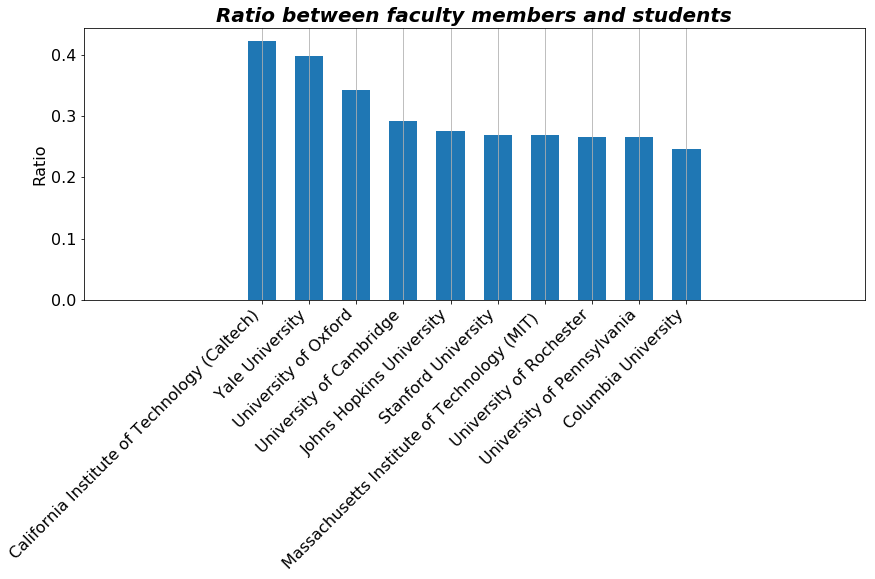

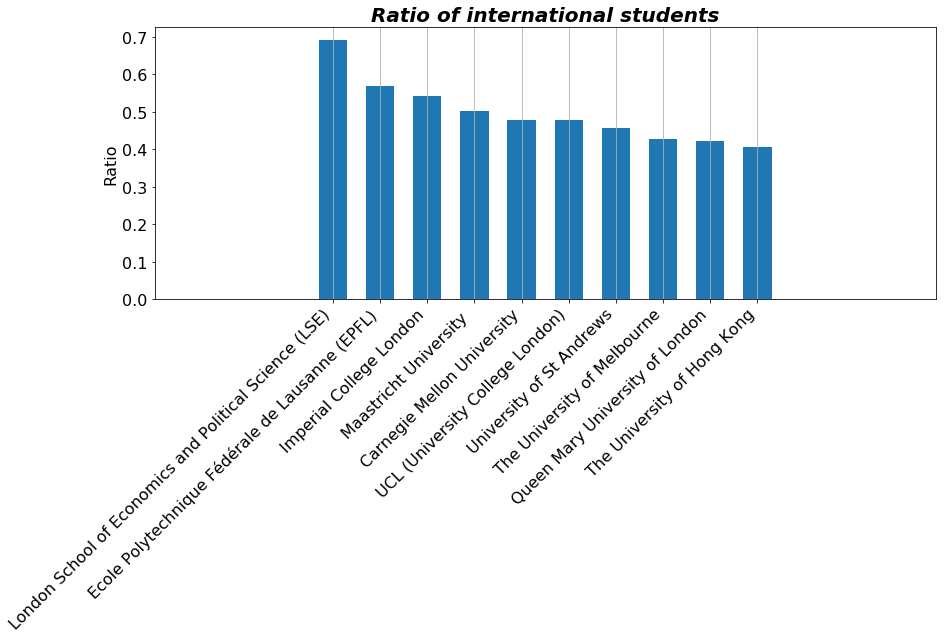

In [14]:
r1, r2 = display_ratio(df)
pretty_bar(r1['ratio'][:10], r1['name'][:10], "Ratio between faculty members and students", "", "Ratio", figwidth=14, rot='vertical', plot_margin=3)
pretty_bar(r2['ratio'][:10], r2['name'][:10], "Ratio of international students", "", "Ratio", figwidth=14, rot='vertical', plot_margin=3)

### c) Grouping by country

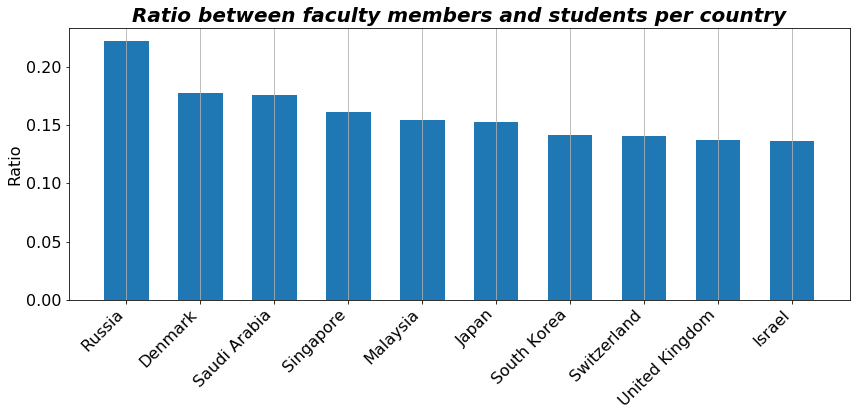

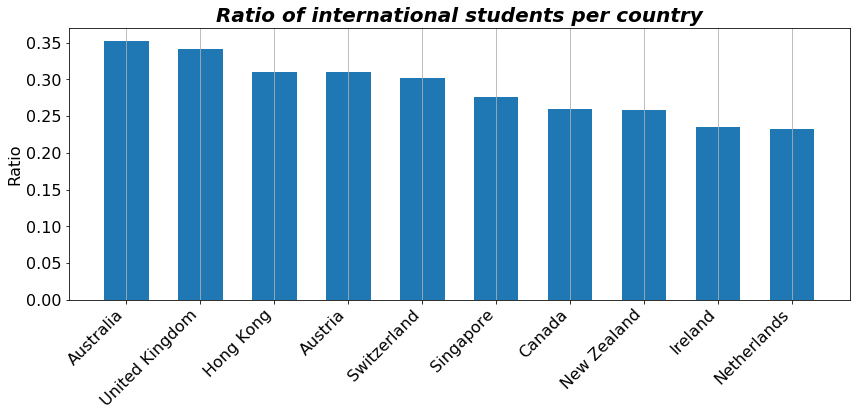

In [15]:
r1, r2 = display_ratio(df.groupby('location').sum().reset_index())
pretty_bar(r1['ratio'][:10], r1['location'][:10], "Ratio between faculty members and students per country", "", "Ratio", figwidth=14, rot='vertical')
pretty_bar(r2['ratio'][:10], r2['location'][:10], "Ratio of international students per country", "", "Ratio", figwidth=14, rot='vertical')

### d) Grouping by region

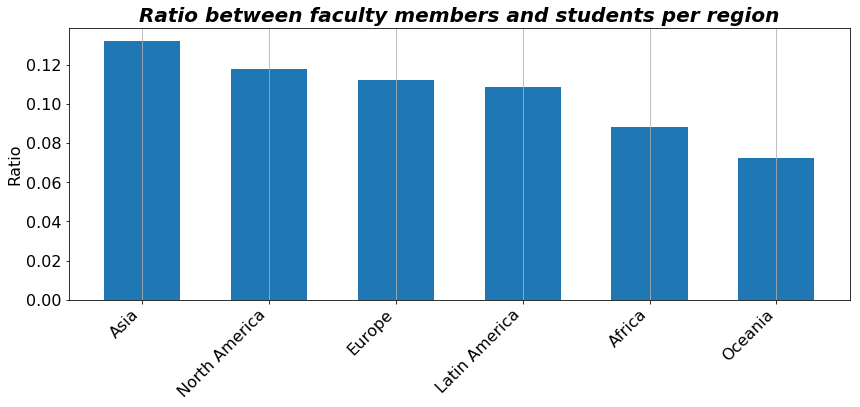

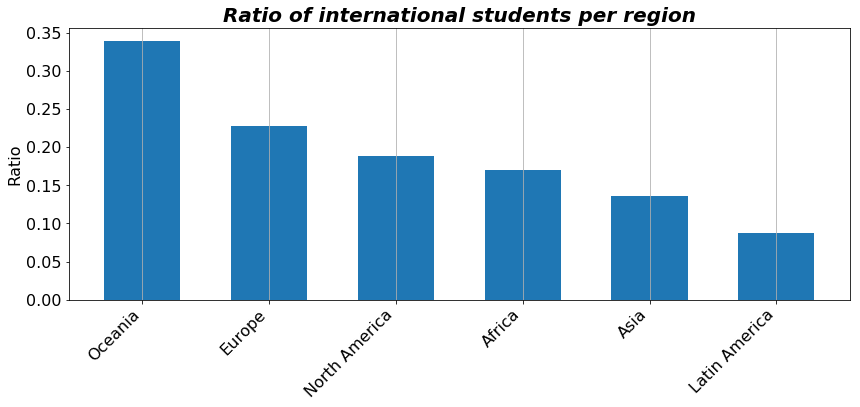

In [16]:
r1, r2 = display_ratio(df.groupby('region').sum().reset_index())
pretty_bar(r1['ratio'][:10], r1['region'][:10], "Ratio between faculty members and students per region", "", "Ratio", figwidth=14, rot='vertical')
pretty_bar(r2['ratio'][:10], r2['region'][:10], "Ratio of international students per region", "", "Ratio", figwidth=14, rot='vertical')

In [17]:
end = datetime.datetime.now()
print(end - start)      

0:00:48.142258


# 2 Time Higher Education data

In [38]:
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
json = r.json()['data']

In [39]:
df_2 = pd.DataFrame(json)
df_2 = df_2[['aliases','name','location','rank','stats_number_students','stats_pc_intl_students','stats_student_staff_ratio']]
df_2 = df_2.head(200)
display(df_2.head(1))

,aliases,name,location,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
0,University of Oxford,University of Oxford,United Kingdom,1,"20,409",38%,11.2


In [40]:
def format_rank(x):
    return int(x.replace('=',''))

def format_percentage_students(x):
    return int(x.replace('%','')) /100

def format_number_students(x):
    return int(x.replace(',',''))

def get_continent(country):
    return ctca2_to_ctn.get(ccn_to_ctca2.get(cn_to_ccn.get(country)))

In [41]:
# TODO: Care for the rank if tie

df_2['stats_pc_intl_students'] = df_2['stats_pc_intl_students'].apply(lambda x: format_percentage_students(x))
df_2['rank'] = df_2['rank'].apply(lambda x: format_rank(x))
df_2['stats_number_students'] = df_2['stats_number_students'].apply(lambda x: format_number_students(x))
df_2['stats_student_staff_ratio'] = df_2['stats_student_staff_ratio'].apply(pd.to_numeric)


df_2['international students'] = df_2['stats_number_students'] * df_2['stats_pc_intl_students']
df_2['total faculty'] = (df_2['stats_number_students'] / df_2['stats_student_staff_ratio']).astype(int)
df_2 = df_2.drop(['stats_pc_intl_students','stats_student_staff_ratio'],1)
df_2['region'] = df_2['location'].apply(lambda x: get_continent(x))

df_2 = df_2.rename(columns={'stats_number_students': 'number of students'})

In [43]:
display(df_2[df_2['region'] == 'Africa'])

,aliases,name,location,rank,number of students,international students,total faculty,region
170,University of Cape Town,University of Cape Town,South Africa,171,20775,3739.5,1775,Africa


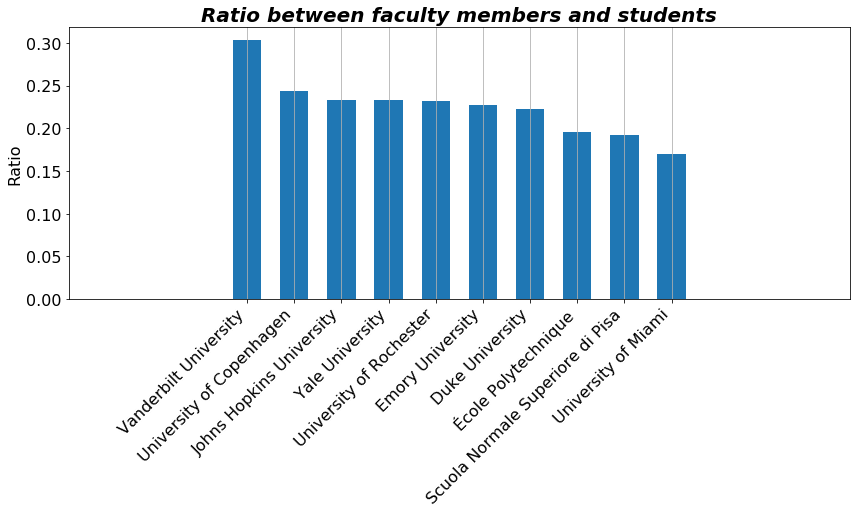

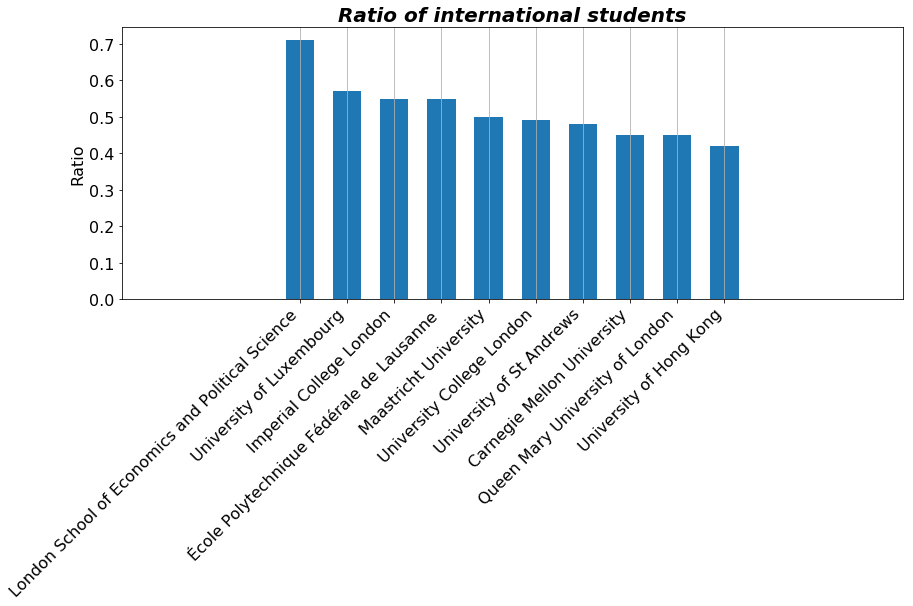

In [23]:
r1, r2 = display_ratio(df_2)
pretty_bar(r1['ratio'][:10], r1['name'][:10], "Ratio between faculty members and students", "", "Ratio", figwidth=14, rot='vertical', plot_margin=3)
pretty_bar(r2['ratio'][:10], r2['name'][:10], "Ratio of international students", "", "Ratio", figwidth=14, rot='vertical', plot_margin=3)

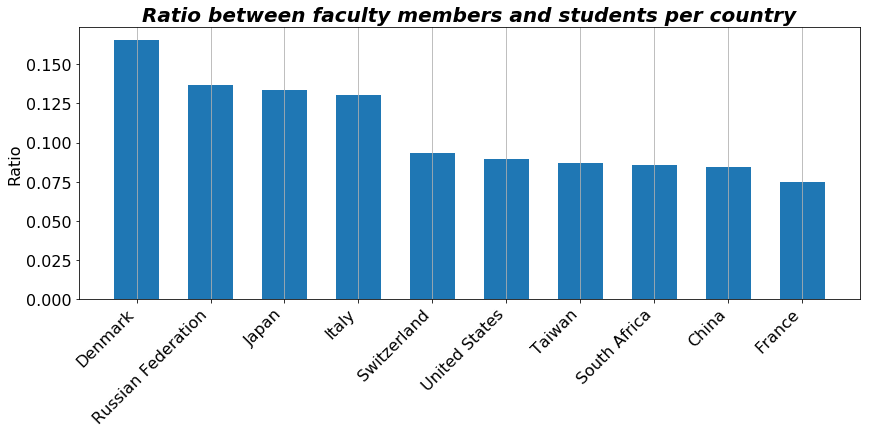

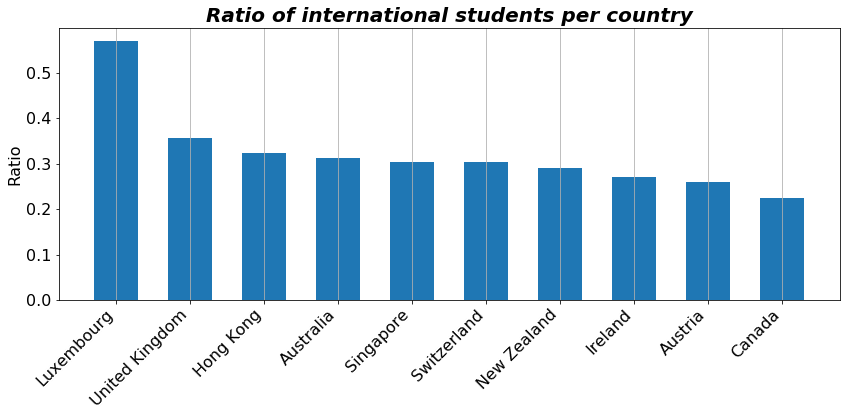

In [24]:
r1, r2 = display_ratio(df_2.groupby('location').sum().reset_index())
pretty_bar(r1['ratio'][:10], r1['location'][:10], "Ratio between faculty members and students per country", "", "Ratio", figwidth=14, rot='vertical')
pretty_bar(r2['ratio'][:10], r2['location'][:10], "Ratio of international students per country", "", "Ratio", figwidth=14, rot='vertical')

,region,rank,number of students,international students,total faculty,ratio
0,Africa,171,20775,3739.50,1775,0.085439
3,North America,5197,1954934,336270.47,165553,0.084685
1,Asia,1674,467914,72065.77,38117,0.081462
2,Europe,11771,2143623,481578.91,126816,0.059160
4,Oceania,808,298978,92612.57,11551,0.038635


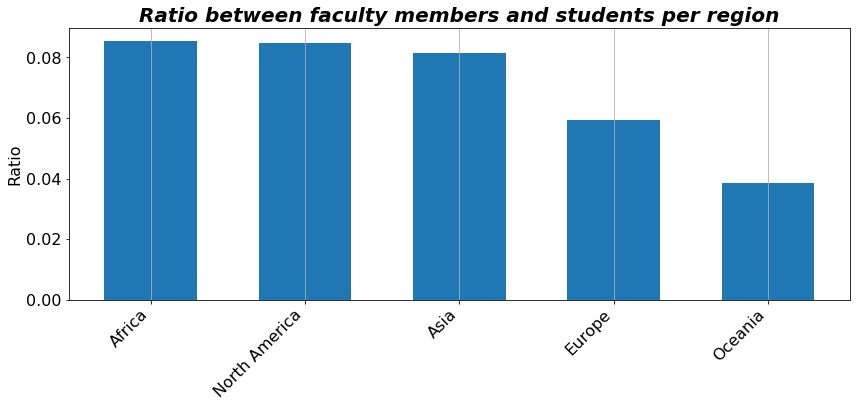

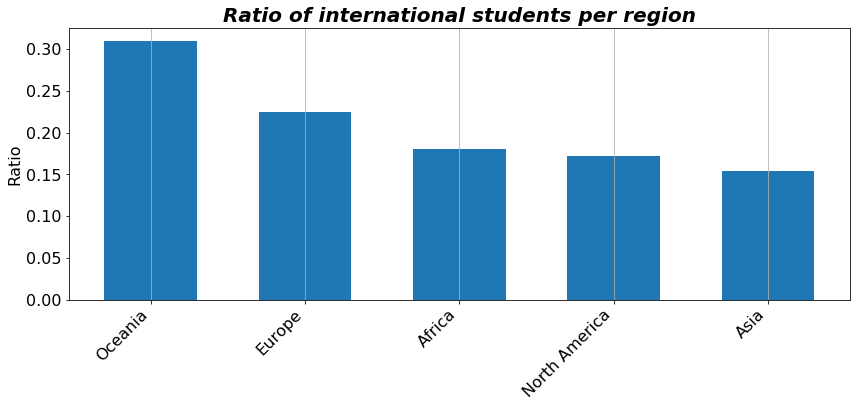

In [47]:
r1, r2 = display_ratio(df_2.groupby('region').sum().reset_index())
pretty_bar(r1['ratio'][:10], r1['region'][:10], "Ratio between faculty members and students per region", "", "Ratio", figwidth=14, rot='vertical')
pretty_bar(r2['ratio'][:10], r2['region'][:10], "Ratio of international students per region", "", "Ratio", figwidth=14, rot='vertical')